In [3]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import skimage
from skimage import io as skio
import numpy
from PIL import ImageEnhance
path =Path("D:/pytorch/data/2D_FishAge")
Path.BASE_PATH =path
image_list = (path/'images').ls()

In [4]:
# #Data processing only.
# #Potential problem here, the 16bit images is squished into a narrow float range before being normalized out to 0-1
# #Attempting to use tensors for speed when scaling to 3D GB data

# #added - add 3 columns and reshape to a 3channel image to make it easier to use with the fastai model batching
# image_tensors = [tensor(skimage.img_as_float( np.transpose( np.repeat( np.asarray(Image.open(o))[:, :, np.newaxis], 3, axis=2), (2,0,1)) )) for o in image_list]
# #normalize the dataset to min-max
# stacked_images_tensor = torch.stack(image_tensors)
# stacked_images_tensor.shape
# max = torch.max(stacked_images_tensor)
# min = torch.min(stacked_images_tensor)
# #considering min*0.98 and max*0.98 to reduce error from speckles
# normal_stacked_images_tensor = (stacked_images_tensor-min)/(max-min)
# # df = pd.DataFrame(image1_tensor)
# # df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

# ##########################################
# ## Replace this all with a better dataloader
# ## Requires dummy files to be in place in the images folder
# ## ADD TO TFMS??https://forums.fast.ai/t/how-to-use-segmentationdataloaders-correctly/88226/11
# #########################################

# numpy_array = [(o.numpy()*255).astype(numpy.uint8) for o in normal_stacked_images_tensor]

# from tifffile import imsave
# image_list_output = (path/'images').ls()
# zippy = zip(image_list_output, (numpy_array))
# #list(zippy)
# [imsave(str(a),b) for a,b in zippy]

In [5]:
fnames = get_image_files(path/"images")


In [11]:
#minutes between time points
minutes=15
fnames = get_image_files(path/"images")
def name_to_hrs (r): return float(round(float(os.path.basename(r)[0:-4].split("_")[1][1:])*(minutes/60)+5,2))
def validation_split (r):  return os.path.basename(r)[0:-4].split("_")[3] == "R0003" or os.path.basename(r)[0:-4].split("_")[3] == "R0006"
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                  get_items = get_image_files,
                  get_y= name_to_hrs,
                  splitter = FuncSplitter(validation_split),
                  batch_tfms =[*aug_transforms(size=(512,512), flip_vert=True), Normalize()]
                  )
dls = dblock.dataloaders(path, bs=16)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


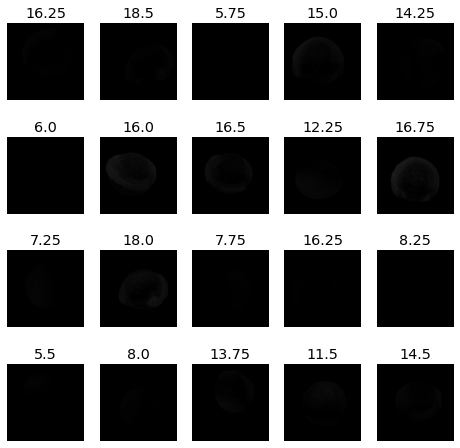

In [12]:

dls.show_batch(max_n=20, figsize=(8,8))

In [13]:
learn = vision_learner(dls, resnet18, y_range=(4.9,24)).to_fp16()

C:\Users\MichaelSNelson\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\MichaelSNelson\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0006918309954926372)

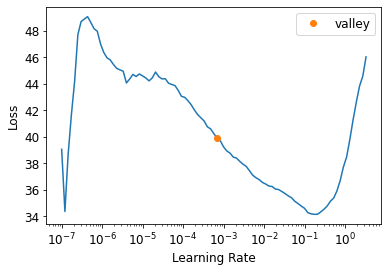

In [14]:
learn.lr_find()

In [16]:
lr = 0.0006
learn.fine_tune(50, lr)

epoch,train_loss,valid_loss,time
0,6.292203,1.858749,00:06


epoch,train_loss,valid_loss,time
0,6.391156,1.893471,00:06
1,6.135580,2.452589,00:06
2,5.964666,2.597152,00:06
3,5.675570,2.443527,00:06
4,5.603038,2.242337,00:06
5,5.533268,2.298309,00:06
6,5.513060,1.884588,00:06
7,5.306555,2.143530,00:06
8,5.319031,2.046878,00:06
9,5.235893,1.986440,00:06


KeyboardInterrupt: 

In [17]:
learn.to_fp32()
learn.unfreeze
learn.fit_one_cycle(50, lr_max=slice(1e-6, 2e-3))

epoch,train_loss,valid_loss,time
0,2.581509,1.625491,00:10
1,2.436588,1.590745,00:08
2,2.675811,1.892878,00:08
3,2.452414,0.895326,00:08
4,2.622887,2.229504,00:08
5,2.827476,1.952265,00:08
6,2.880080,2.175913,00:08
7,2.749575,1.427298,00:08
8,2.779392,1.542408,00:08
9,2.639818,0.984491,00:08


In [211]:
learn.export('export.pkl')

In [210]:
learn.path = Path("D:/pytorch/data/2D_FishAge")

In [212]:
zebrafish_age_predictor = load_learner(path/'export.pkl')


In [1]:
n=1080
print(os.path.basename(fnames[n]))
img = plt.imread(fnames[n])
age,tensor, tensor=zebrafish_age_predictor.predict(img)
print("Estimated age is "+str(round(age[0],2))+"hrs.")
plt.figure(figsize=(4,4))

plt.axis('off')
plt.imshow(img*10)


NameError: name 'fnames' is not defined

In [281]:
# IGNORE FOR NOW
#attempt to make a GUI for Voila
out_pl = widgets.Output()
lbl_pred = widgets.Label()
zebrafish_age_predictor = load_learner(path/'export.pkl')
btn_run = widgets.Button(description='Process')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    enhancer = ImageEnhance.Brightness(img)
    factor = 10 
    im_output = enhancer.enhance(factor)
    with out_pl: display(im_output.to_thumb(128,128))
    age,tensor, tensor=zebrafish_age_predictor.predict(img)
    lbl_pred.value = f'Predicted age: {age[0]};'

btn_run.on_click(on_click_classify)

In [286]:
btn_upload= widgets.FileUpload()

In [287]:
VBox([widgets.Label('Upload a grayscale zebrafish embryo image'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [252]:
zebrafish_age_predictor.predict(img)

((18.362674713134766,), TensorBase([18.3627]), TensorBase([18.3627]))